In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO

In [2]:
import os
print(os.getcwd())

/home/deck/_venv/_git/Python_2024/graphs


In [3]:
def rd(x,y=0):
    ''' A classical mathematical rounding by Voznica '''
    try:
        m = int('1'+'0'*y) # multiplier - how many positions to the right
        q = x*m # shift to the right by multiplier
        c = int(q) # new number
        i = int( (q-c)*10 ) # indicator number on the right
        if i >= 5:
            c += 1
        result = '{num:.{prec}f}'.format(num=c/m,prec=y)
    except:
        result = ''
    return result

In [4]:
def rd(number, decimal_places=2, decimal_separator={'.':','}, minus_sign='-', thousands_separator={' ':' '}, integer_places=0,
       round_type='5up', prefix='', suffix='', verbose=False) -> str:
    """Cerny rounding"""
    if verbose: print('Cislovani pozic je od 0!')
    #round_type=['None', '5up', 'Floor', 'Ceiling']
    round_up = {'0':'1', '1':'2', '2':'3', '3':'4', '4':'5', '5':'6', '6':'7', '7':'8', '8':'9', '9':'0'}
    decimal_separator_out=decimal_separator[list(decimal_separator.keys())[0]]
    decimal_separator=list(decimal_separator.keys())[0]
    separate_thousands=False
    thousands_separator_out=thousands_separator[list(thousands_separator.keys())[0]]
    thousands_separator=list(thousands_separator.keys())[0]
    if thousands_separator_out != '':
        separate_thousands=True
    ret_string = ''
    raw_string = str(number).strip()
    raw_string = raw_string.replace(thousands_separator, '')
    minus_place = raw_string.find(minus_sign)
    raw_string = raw_string.replace(minus_sign, '')
    decimal_place = raw_string.find(decimal_separator)
    # když začíná .tak mi to nefunguje
    if decimal_place == 0:
        raw_string = '0' + raw_string
        decimal_place = 1
    raw_string = raw_string.replace(decimal_separator, '')
    raw_string = ''.join([x for x in raw_string if x in round_up])
    if decimal_place == -1:
        decimal_place = len(raw_string)
    if verbose: print('decimal_place', decimal_place)
    if verbose: print('raw_string', raw_string)
    if round_type != 'None':
        # potrebuju se dostat na decision_number
        decision_place = decimal_place + decimal_places
        if verbose: print('decision_place', decision_place)
        if (decision_place < 0):
            # zaokrouhluju 999 na -4 a vic des.mist a víc, takže 1000 na -4 je 0000
            if verbose: print('decision_place je < 0, vratim 0')
            ret_string = '0'
            decimal_place = 1
            #decimal_place = abs(decimal_places)
        elif (decision_place >= len(raw_string)):
            # vratim cele a nasledne dodelam '0' na dalsich des mistech
            if verbose: print('decision_place je >= len(raw_string):', len(raw_string), '- vratim cele a dodelam 0')
            ret_string = raw_string
        else:
            #jdu zaokrouhlovat
            if raw_string[decision_place] in ('0', '1', '2', '3', '4') and round_type != 'Ceiling' or round_type == 'Floor':
                #zaokrouhluju dolu
                ret_string += raw_string[:decision_place]
                if verbose: print('zaokrouhluju dolu, decision number je:', raw_string[decision_place], ', vracím:', ret_string)
            else:
                #zaokrouhluju nahoru
                for i in range (decision_place, -1, -1):
                    if i == 0:
                        ret_string = '1'
                        decimal_place += 1
                        if verbose: print('jsem na nultém místě a mám to zaokrouhlit nahoru, vracím 1 a ostatní doplním 0 až do decimal place:', decimal_place)
                        break
                    else:
                        if raw_string[(i-1)] != '9':
                            ret_string = raw_string[:(i-1)] + round_up[raw_string[(i-1)]]
                            if verbose: print('hotovo, decision number je:', raw_string[i], 'na místě:', i, 'a předchozí není 9, vracím:', ret_string)
                            break
                        if verbose: print('zaokrouhluju nahoru, decision number je:', raw_string[i], 'na místě:', i)
        # pokud jsem zaokrouhloval na - des mista, meno bylo typ 799.9, tak musim doplnit chybejici 0
        # ta je bud do des. mista, nebo do abs(decimal_places), pokud jdem zadal abs(-decimal_places) > decimal_place
        if len(ret_string) < decimal_place:
            ret_string += '0'*(decimal_place - len(ret_string))
    else:
        ret_string = raw_string
    # doplnim des. čárku a chybějící des. místa
    if len(ret_string) > decimal_place - decimal_places:
        ret_string=ret_string[:decimal_place] + decimal_separator_out + ret_string[decimal_place:]
        if len(ret_string) - decimal_place <= decimal_places:
            ret_string += '0'*(decimal_places - (len(ret_string) - decimal_place) + 1)
    if decimal_place < integer_places:
        ret_string = '0'*(integer_places - decimal_place) + ret_string
        decimal_place = integer_places
    # nechci přidat mínus k nule!
    try:
        x = float(ret_string)
        if x == 0 and minus_place > -1:
            minus_place = -1
    except Exception as e:
        pass
    if separate_thousands:
        for i, j in enumerate(range(decimal_place -1, -1, -1)):
            #print(ret_string[j])
            if i % 3 == 2 and j > 0:
                ret_string=ret_string[:j] + thousands_separator_out + ret_string[j:]
    if minus_place > -1:
        ret_string = minus_sign + ret_string
    return prefix + ret_string + suffix

In [5]:
def getBarChart(df, columns = [], kind='v', rounding={'decimal_places':0}, normalize=False, reverse=False, total=False,
                title='', label='', limit=(None, None), width=0.8, rotation=0, figsize=(5, 5), file='', html=False):
    '''Tato funkce vytváří grafy s popisky hodnot'''
    if kind =='v' or kind =='vs' or kind =='h' or kind =='hs':
        # šaráda s cols je kvůli False, True v názvech sloupců (viz Titanic)
        cols = []
        if columns != []:
            for i, column in enumerate(columns):
                cols.append(df.columns.get_loc(column))
        else:
            for i, column in enumerate(df.columns):
                cols.append(df.columns.get_loc(column))
        
        df = df.iloc[:, cols]
        columns = df.columns
        if total == True or total == 'sum':
            df.loc['Total (sum)'] = df.sum()
        elif total == 'mean':
            df.loc['Total (mean)'] = df.mean()
        if normalize:
            df = df.div(df.sum(axis=1), axis=0)*100
        if reverse:
            df = df[::-1]
        left_bottom = None
        right_top = None
        if len(limit) == 2:
            left_bottom = limit[0]
            right_top = limit[1]
        fig, ax = plt.subplots(figsize = figsize)
        rectss = []
        bottom = np.zeros(len(df))
        ticks = np.arange(len(df))  # the x/y ticks locations
        width1 = 0    # pro popisky
        if  kind =='v' or  kind =='h':
            width = width / len(columns) #0.25  # the width of the bars
            width1 = width/2*(len(columns)-1)
        if reverse:
            multiplier = len(columns)-1
        else:
            multiplier = 0
        if kind =='v' or kind =='vs':
            for column in columns:
                offset = width * multiplier
                if kind =='vs':
                    rectss.append(ax.bar(x=ticks, height=df[column], bottom=bottom, width=width, label=column))
                elif kind =='v':
                    rectss.append(ax.bar(x=ticks + offset, height=df[column], width=width, label=column))
                if reverse:
                    multiplier -= 1
                else:
                    multiplier += 1
                bottom += np.array(df[column])
            bottom = np.zeros(len(df))
            for rects in rectss:
                bott = []
                for i, rect in enumerate(rects):
                    if len(columns) == 1 or kind =='v':
                        ax.annotate(text=rd(rect.get_height(), **rounding), xy=(rect.get_x() + rect.get_width()/2, rect.get_height()), ha='center', va='bottom')
                    else:
                        ax.annotate(text=rd(rect.get_height(), **rounding), xy=(rect.get_x() + rect.get_width()/2, rect.get_height()/2 + bottom[i]), ha='center', va='center')
                    bott.append(rect.get_height())
                bottom += np.array(bott)
            if rotation > 0 and rotation < 90:
                ax.set_xticks(ticks + width1, df.index, rotation = rotation, rotation_mode='anchor', ha='right')
            else:
                ax.set_xticks(ticks + width1, df.index, rotation = rotation)
            ax.set_xlabel(df.index.name)
            ax.set_ylabel(label)
            ax.set_ylim(bottom=left_bottom, top=right_top)
            #ax.set_xticks(x + width, species)
        if kind =='h' or kind =='hs':
            for column in columns:
                offset = width * multiplier
                if kind =='hs':
                    rectss.append(ax.barh(y=ticks, width=df[column], left=bottom, height=width, label=column))
                elif kind =='h':
                    rectss.append(ax.barh(y=ticks + offset, width=df[column], height=width, label=column))
                if reverse:
                    multiplier -= 1
                else:
                    multiplier += 1
                bottom += np.array(df[column])
            bottom = np.zeros(len(df))
            for rects in rectss:
                bott = []
                for i, rect in enumerate(rects):
                    if len(columns) == 1 or kind =='h':
                        ax.annotate(text=rd(rect.get_width(),**rounding), xy=(rect.get_width(), rect.get_y()+rect.get_height()/2), ha='left', va='center')
                    else:
                        ax.annotate(text=rd(rect.get_width(),**rounding), xy=(rect.get_width()/2+bottom[i], rect.get_y()+rect.get_height()/2), ha='center', va='center')
                    bott.append(rect.get_width())
                bottom += np.array(bott)
            if rotation > 0 and rotation < 90:
                ax.set_yticks(ticks + width1, df.index, rotation = rotation, rotation_mode='anchor', ha='right')
            else:
                ax.set_yticks(ticks + width1, df.index, rotation = rotation, va='center')
            ax.set_xlabel(label)
            ax.set_xlim(left=left_bottom, right=right_top)
            ax.set_ylabel(df.index.name)
        ax.legend(title=df.columns.name, loc='upper center', bbox_to_anchor=(1.1, 1), ncol=1, fancybox=True, shadow=True)
        ax.set_title(title)
        if file != '':
            fig.savefig(file, dpi=fig.dpi, bbox_inches='tight')
        if html:
            buf = BytesIO()
            fig.savefig(buf, format="png", bbox_inches='tight')
            # Embed the result in the html output.
            data = base64.b64encode(buf.getbuffer()).decode("ascii")
            return f"<img src='data:image/png;base64,{data}'/>"
    else:
        raise Exception("Sorry, wrong type(only accept 'h', 'hs', 'v', 'vs')")

In [6]:
df = pd.DataFrame({'Boys': [67, 78],
                         'Girls': [72, 80], },
                        index=['First Year', 'Second Year'])
df

,Boys,Girls
First Year,67,72
Second Year,78,80


<Axes: >

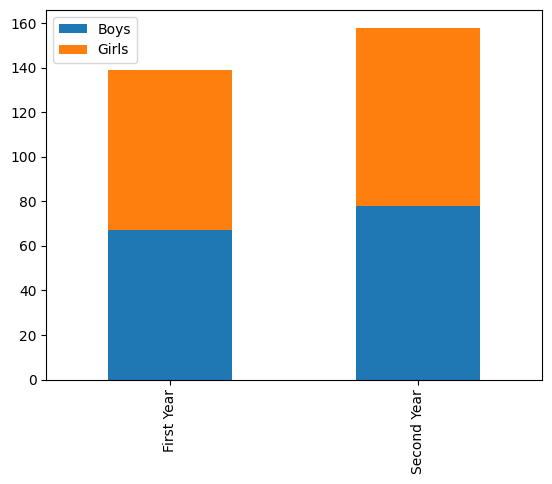

In [7]:
df.plot(kind='bar', stacked=True)

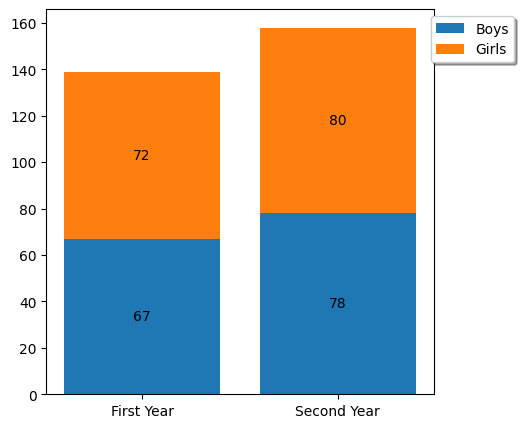

In [8]:
getBarChart(df, kind='vs')

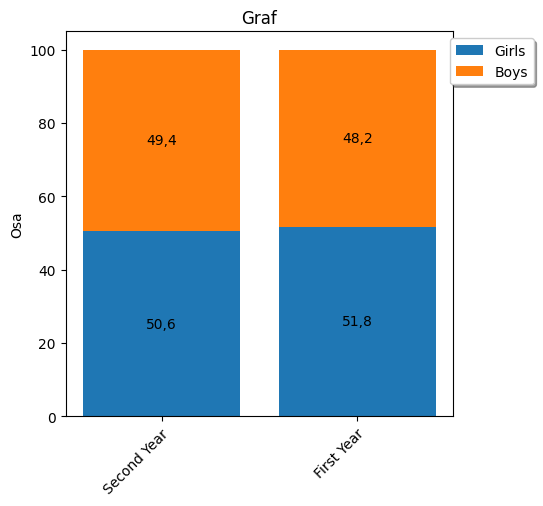

In [9]:
#df, columns = [], type='v', precision=0, normalize=False, title='Title', label='Label',
                # width=0.8, rotation=0, figsize=(5, 5), file='', html=False
html = getBarChart(df, columns=['Girls', 'Boys'], kind='vs', reverse=True, rounding={'decimal_places':1}, normalize=True, title='Graf', label='Osa', width=0.8, rotation=45, figsize=(5, 5), html=True)

In [10]:
from ipywidgets import widgets, Layout, HBox, HTML
HTML(html)

HTML(value="<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAh8AAAH6CAYAAACnPC59AAAAOnRFWHRTb2Z0d2FyZQ…

In [11]:
html[:100]+'...'

"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAh8AAAH6CAYAAACnPC59AAAAOnRFWHRTb2Z0d2FyZQBN..."

In [12]:
with open ('plot.html', 'w') as file:
    file.write(html)

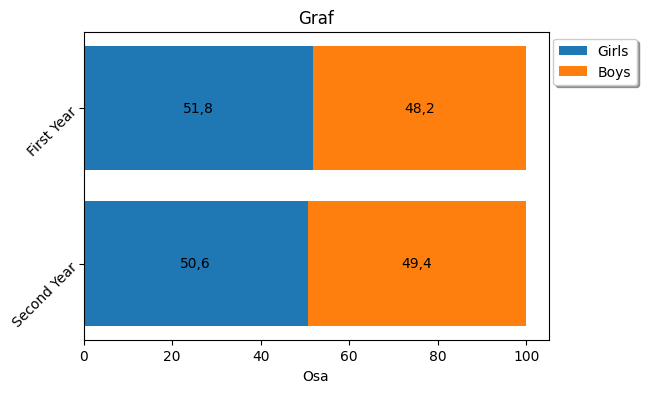

In [13]:
# dodělat plot.png
#plt.savefig('plot.png', bbox_inches='tight')
getBarChart(df, columns=['Girls', 'Boys'], kind='hs', reverse=True, rounding={'decimal_places':1}, normalize=True, title='Graf', label='Osa', width=0.8, rotation=45, figsize=(6, 4), file='plot.png')

![graf](plot.png)